# [Source](https://langchain-ai.github.io/langgraph/tutorials/get-started/6-time-travel/)

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_ollama import ChatOllama
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

In [2]:
llm = ChatOllama(
    model=os.getenv("ollama_model"),
    reasoning=True,
)

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
graph_builder = StateGraph(State)

In [5]:
tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

In [6]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [7]:
graph_builder.add_node("chatbot", chatbot)

In [8]:
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [9]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [10]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [11]:
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

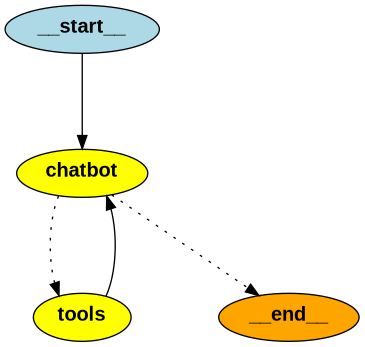

In [12]:
g = graph.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [13]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (949a4952-5f50-4fac-bc9c-e8d88d0d9d52)
 Call ID: 949a4952-5f50-4fac-bc9c-e8d88d0d9d52
  Args:
    query: LangGraph
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ibm.com/think/topics/langgraph", "title": "What is LangGraph? - IBM", "content": "LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At it

In [14]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

## 🚀 Building an Autonomous Agent with LangGraph: A Quick‑Start Playbook

Below is a **step‑by‑step guide** that takes you from “I just installed LangGraph” to “my agent is alive, talks to a human, calls a web API, and stores its state in a database.”  Feel free to skip or reorder steps—just keep the overall flow in mind.

| # | What you’ll do | Key Concepts | Tools/Packages |
|---|----------------|--------------|----------------|
| 1 | **Define the Problem** | Clarify *goal*, *inputs*, *outputs*, *constraints* | ✍️ |
| 2 | **Choose LLM & Toolset** | OpenAI GPT‑4o, Anthropic Claude, HuggingFace, or a custom model | `langchain-core`, `langchain-openai` |
| 3 | **Model the Workflow** | Map out steps: gather data → decide action → call tool → iterate | Flowchart (

In [36]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 10:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  12 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  12 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  11 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  10 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  10 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  9 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
----------------------------------------------

In [37]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f09ba51-aec7-67a9-8009-ced9c681b698'}}


In [38]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

## Quick‑look: What LangGraph is

| Aspect | Details |
|--------|---------|
| **Created by** | LangChain (Python library) |
| **Core idea** | A *low‑level* orchestration framework that lets you build, deploy, and manage **stateful, long‑running agent workflows** using graph‑based models. |
| **Key differentiators** | • Durable, streaming execution<br>• Human‑in‑the‑loop support<br>• Cyclical and multi‑agent coordination<br>• Flexible state storage (SQL, NoSQL, cloud buckets) |
| **Typical use‑cases** | • Multi‑agent chatbots (e.g., customer‑service + scheduling)<br>• Knowledge‑base browsing agents<br>• Robotics control loops<br>• Data‑processing pipelines that need back‑and‑forth reasoning |

> *“LangGraph is an open‑source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize la

In [39]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "That wasn't really helpful. "
                    "Can you look up for better information?"
                ),
            },
        ],
    },
    to_replay.config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

That wasn't really helpful. Can you look up for better information?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (6dec842f-8d0d-4303-8a8c-bfc54b0f3a1c)
 Call ID: 6dec842f-8d0d-4303-8a8c-bfc54b0f3a1c
  Args:
    query: LangGraph architecture diagram
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph architecture diagram", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://medium.com/@shuv.sdr/langgraph-architecture-and-design-280c365aaf2c", "title": "LangGraph — Architecture and Design | by Shuvrajyoti Debroy", "content": "# Visualization — Multi-Agent Workflow Graph\n\n Workflows can be visualized as Mermaid diagrams, making it easier to see nodes, edges, and branching logic.\n This improves debugging and und